In [ ]:
!git clone https://github.com/nirnayroy/OrderChaosHNN.git
%cd /content/OrderChaosHNN

Cloning into 'OrderChaosHNN'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 111 (delta 62), reused 52 (delta 21), pack-reused 0
Receiving objects: 100% (111/111), 4.09 MiB | 28.68 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/OrderChaosHNN


In [ ]:
!python main.py

Successfully loaded data from /content/OrderChaosHNN/Square_DSR_0.1-orbits-dataset_RK45_EnsemblesPerEnergy_10_OrbitLen_1000_Resolution_10000_energyPoints10.pkl
Hidden dimensions (excluding first and last layer) : [200, 200]
Training data size : (700000, 4)
Testing data size : (300000, 4)
Training baseline model ...
Using Tanh()...
ModuleList(
  (0): Linear(in_features=4, out_features=200, bias=True)
  (1): Linear(in_features=200, out_features=200, bias=True)
)
Epochs:   0% 0/2 [00:00<?, ?it/s]
Batches:   0% 0/1367 [00:00<?, ?it/s]
Batches:   0% 2/1367 [00:00<01:37, 14.00it/s]
Batches:   0% 4/1367 [00:00<01:30, 15.05it/s]
Batches:   0% 6/1367 [00:00<01:23, 16.25it/s]
Batches:   1% 8/1367 [00:00<01:20, 16.97it/s]
Batches:   1% 11/1367 [00:00<01:16, 17.71it/s]
Batches:   1% 13/1367 [00:00<01:13, 18.33it/s]
Batches:   1% 15/1367 [00:00<01:12, 18.52it/s]
Batches:   1% 17/1367 [00:00<01:11, 18.75it/s]
Batches:   1% 19/1367 [00:01<01:14, 18.16it/s]
Batches:   2% 21/1367 [00:01<01:12, 18.55it/

In [ ]:
import matplotlib.pyplot as plt
import torch, time, sys
import numpy as np
from math import sqrt
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

EXPERIMENT_DIR = 'TrainedNetworks'
sys.path.append(EXPERIMENT_DIR)

from baseline_nn import BLNN
from hnn import HNN
from utils import  to_pickle, from_pickle
from data import DynamicalSystem
from tqdm import tqdm

## Set some notebook constants

In [ ]:
DPI = 300
FORMAT = 'pdf'
DSR = 0.1

def get_args():
    return {'input_dim': 4,
         'hidden_dim': [200,200],
         'learn_rate': 1e-3,
         'input_noise': 0.0,
         'batch_size': 512,
         'epochs': 1,
         'hamiltonian': '''(p1**2+p2**2)/(2)-((
        (1/(1+(exp(-(q1+2)/0.1))))-(1/(1+(exp(-(q1-2)/0.1)))))*(
        (1/(1+(exp(-(q2+2)/0.1))))-(1/(1+(exp(-(q2-2)/0.1))))))+1''',
         'energy': 0.14671332365966105, # Range [0.02 0.16]
         'integrator': "RK45", #[RK45, RK4, Symplectic]
         'verbose': True,
         'name': 'Square_DSR_{}'.format(DSR),
         'seed': 957,
         'save_dir': '{}'.format(EXPERIMENT_DIR),
         'fig_dir': './figures'}

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

## Instantiating args 

In [ ]:
args = ObjectView(get_args())

## Visualize one example from dataset

In [ ]:

# seeting a fixed seed 
np.random.seed(args.seed)

tspan = [0,500] # integration time 

tpoints = int(tspan[1]*(1.0/DSR)) # resolution of time series 
print('No. of orbit points : {}'.format(tpoints))

state_symbols = ['q1','q2','p1','p2']

# Instantiating the dynamical systems using args
sys = DynamicalSystem(sys_hamiltonian=args.hamiltonian,state_symbols=state_symbols,
                      tspan=tspan,timesteps=tpoints,integrator=args.integrator,
                      symplectic_order=4)

# sampling consistent initial conditions using energy expression 
result = False
while not result:
    with np.errstate(invalid='raise'):
        try:
            r1, r2 = 4*np.random.random(2)-2
            angle = 2*np.pi*np.random.random()-np.pi
            q1, q2 = r1, r2
            p1 = 0.5*np.sin(angle)
            p2 = 0.5*np.cos(angle)
            result = True 
        except FloatingPointError:
            continue

state = np.array([q1, q2, p1, p2])

print('Initial Condition : {}'.format(state))
print('Energy : {}'.format(sys.get_energy(state)))

orbit, settings = sys.get_orbit(state)
sys.get_energy(orbit)
print('Shape of the orbit : {}'.format(orbit.shape))


No. of orbit points : 5000
Initial Condition : [ 1.61921222 -0.24478578  0.01178869 -0.49986101]
Energy : 0.14671332365966105
Shape of the orbit : (4, 5000)


## Visualizing a sample trajectory

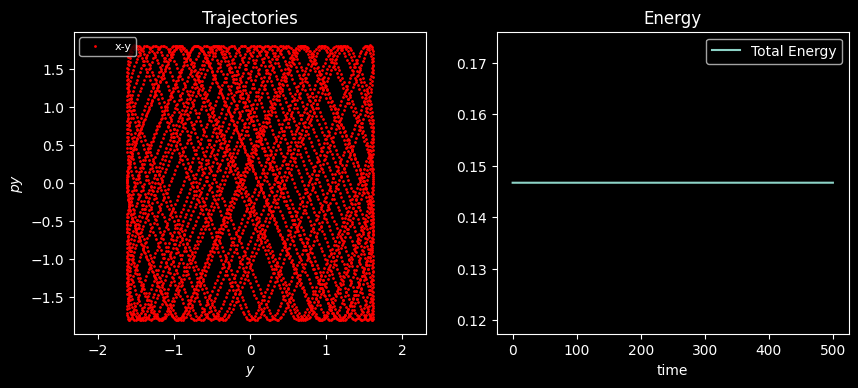

In [ ]:
# draw trajectory
fig = plt.figure(figsize=[10,4], dpi=100)

# using dark background style sheet for all plots
plt.style.use('dark_background')

plt.subplot(1,2,1)
plt.title('Trajectories')
plt.plot(orbit[0,:], orbit[1,:],  '.r', label='x-y',markersize=2)
plt.axis('equal')
plt.xlabel('$y$') ; plt.ylabel('$py$')
plt.legend(fontsize=8, loc='best')

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
z = sys.get_energy(orbit)
plt.plot(settings['t_eval'], z, label='Total Energy')
plt.legend()
y_lim = (0.8*z.min(),1.2*z.max())
plt.ylim(y_lim)



plt.show()
#fig.savefig('{}/orbits-dataset_{}_nlayers_{}_energy_{}_integrator_{}.{}'.format(
#                                                    args.fig_dir,args.name,len(args.hidden_dim),
#                                                    args.energy,args.integrator,FORMAT))

## Load Trained models

In [ ]:
def load_model(args, baseline=False):
    
    if baseline:
        output_dim = args.input_dim
        model = BLNN(args.input_dim, args.hidden_dim,output_dim,'Tanh')
        path = "/content/OrderChaosHNN/TrainedNetworks/Square_DSR_0.1_nlayers_2-orbits-baseline_integrator_RK45_epochs_2_BatchSize_512.tar"
    else:
        output_dim = 1
        nn_model = BLNN(args.input_dim, args.hidden_dim,output_dim,'Tanh')
        model = HNN(args.input_dim,baseline_model=nn_model)
        path = "/content/OrderChaosHNN/TrainedNetworks/Square_DSR_0.1_nlayers_2-orbits-hnn_integrator_RK45_epochs_2_BatchSize_512.tar"
    
    model.load_state_dict(torch.load(path),strict=False)
    return model

args = ObjectView(get_args())
base_model = load_model(args, baseline=True)
hnn_model = load_model(args, baseline=False)
print('----->',base_model)
print('----->',hnn_model)

Using Tanh()...
ModuleList(
  (0): Linear(in_features=4, out_features=200, bias=True)
  (1): Linear(in_features=200, out_features=200, bias=True)
)
Using Tanh()...
ModuleList(
  (0): Linear(in_features=4, out_features=200, bias=True)
  (1): Linear(in_features=200, out_features=200, bias=True)
)
-----> BLNN(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): Linear(in_features=200, out_features=200, bias=True)
  )
  (last_layer): Linear(in_features=200, out_features=4, bias=False)
)
-----> HNN(
  (baseline_model): BLNN(
    (layers): ModuleList(
      (0): Linear(in_features=4, out_features=200, bias=True)
      (1): Linear(in_features=200, out_features=200, bias=True)
    )
    (last_layer): Linear(in_features=200, out_features=1, bias=False)
  )
)


# What has the baseline learned?

In [ ]:
# for integrating a vector field parameterized by a NN or HNN
def model_update(t, state, model):
    state = state.reshape(-1,4)
    deriv = np.zeros_like(state)
   
    x = torch.tensor( state, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv= dx_hat.detach().data.numpy()
    return deriv.reshape(-1)

### Integrate trajectories

In [ ]:
print(sys.time_points)

5000


In [ ]:

# calculating true trajectories
np.random.seed(57845)

sys.time_points = int(1/DSR)*(tspan[1])

sys.integrator ='RK45'

# sampling consistent initial conditions using energy expression 
result = False
while not result:
    with np.errstate(invalid='raise'):
        try:
            r1, r2 = 4*np.random.random(2)-2
            angle = 2*np.pi*np.random.random()-np.pi
            q1, q2 = r1, r2
            p1 = 0.5*np.sin(angle)
            p2 = 0.5*np.cos(angle)
            result = True
        except FloatingPointError:
            continue

state = np.array([q1, q2, p1, p2])


print('Starting State : {}'.format(state))
sys.external_update_fn = None ## Only used when forecasting with NN or HNN (not for true trajectories)
orbit, settings = sys.get_orbit(state)
print('Orbit Shape : {}'.format(orbit.shape))


Starting State : [-0.89291211  1.23272919  0.24680475  0.43484183]
Orbit Shape : (4, 5000)


In [ ]:
# defining update function for baseline model 
update_fn = lambda t, y0: model_update(t, y0, base_model)
sys.external_update_fn = update_fn
sys.integrator = 'RK45'
# calculating baseline forecasts
base_orbit, settings = sys.get_orbit(state)
print('Starting State : {}'.format(state))
print('Orbit Shape : {}'.format(base_orbit.shape))

Using external  function...
Starting State : [-0.89291211  1.23272919  0.24680475  0.43484183]
Orbit Shape : (4, 5000)


### Draw trajectories

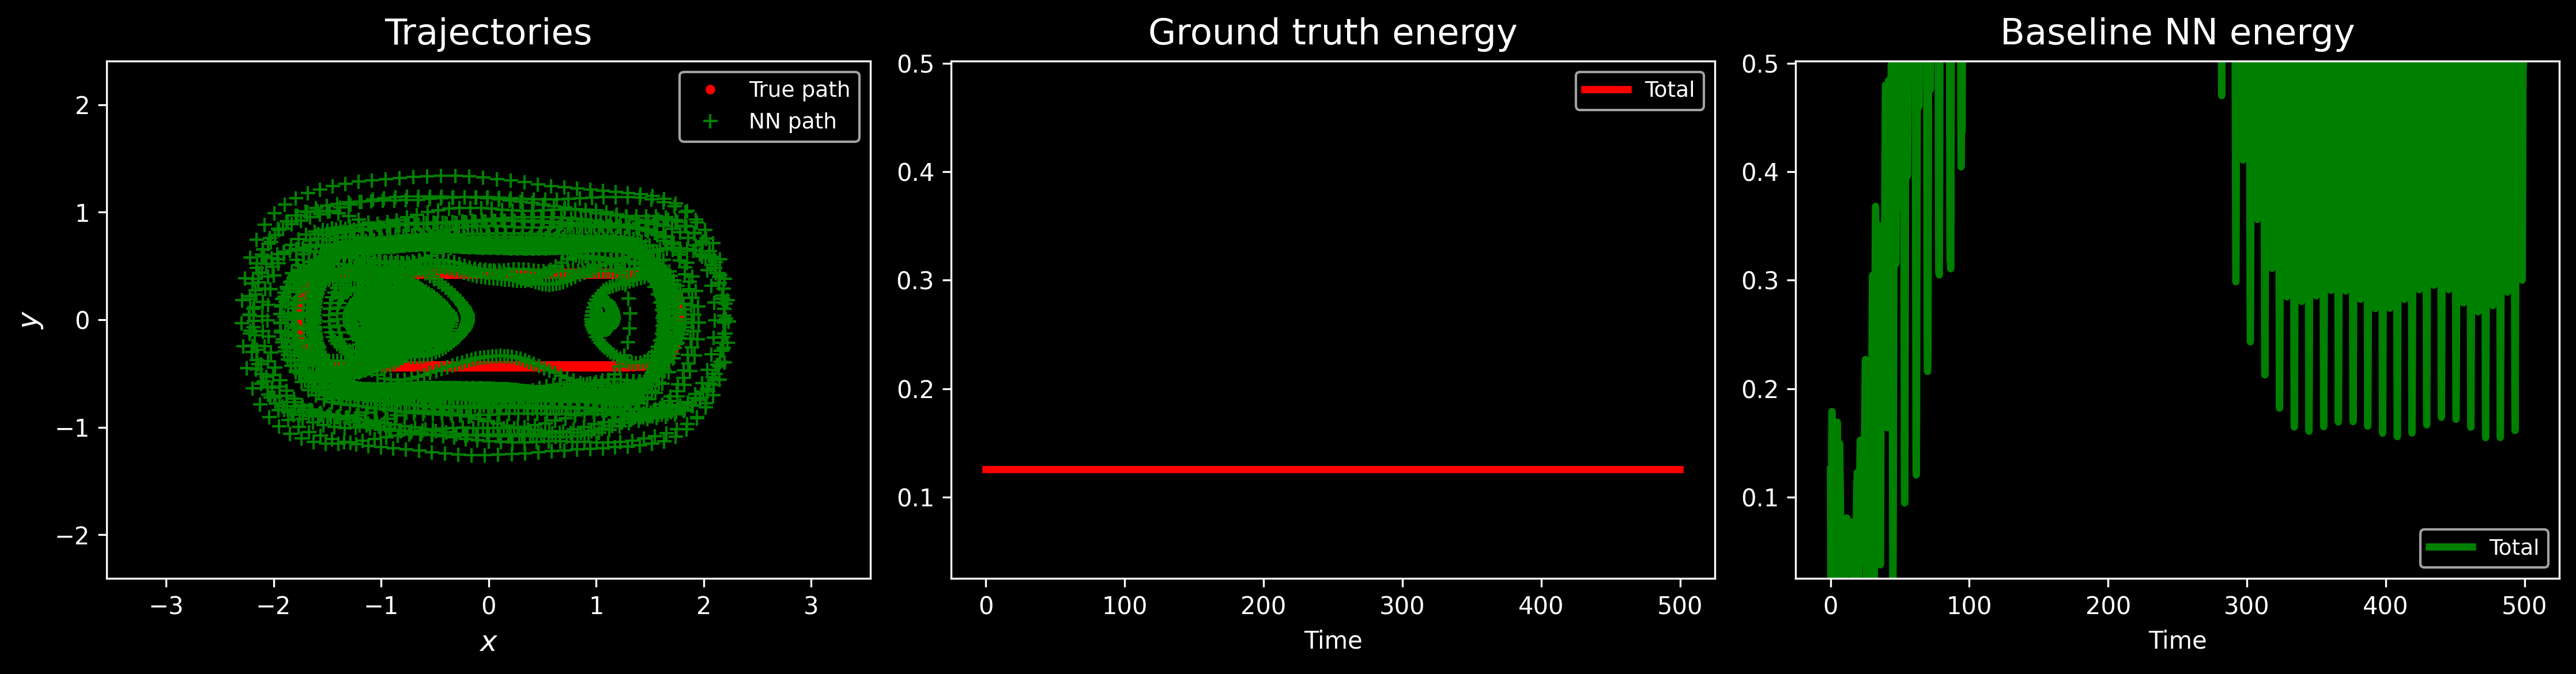

In [ ]:
lw = 3 #linewidth
fs = 9 # font size
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4], dpi=DPI)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['red', 'green']

plt.plot(orbit[1,:], orbit[3,:], '.', c=colors[0], label='True path', linewidth=lw)
plt.plot(base_orbit[1,:], base_orbit[3,:], '+', c=colors[1], label='NN path', linewidth=lw)
plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)
plt.xlim(2.0*np.min(orbit[1,:]), 2.0*np.max(orbit[1,:]))
plt.ylim(2.0*np.min(orbit[3,:]), 2.0*np.max(orbit[3,:]))

plt.subplot(1,3,2)
real_etot = sys.get_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_etot, 'r-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['tspan'])
ymin = 0.2*real_etot.min() 
ymax = 4*real_etot.max()
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], sys.get_energy(base_orbit), 'g-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['tspan'])
plt.ylim(ymin, ymax)
#plt.yscale('log')

plt.tight_layout() ; plt.show()
#fig.savefig('{}/orbits-baseline_{}_nlayers_{}integrator_{}.{}'.format(args.fig_dir, args.name,
#                                                len(args.hidden_dim),args.integrator, FORMAT))

## What has the HNN learned?

### Integrate trajectories

In [ ]:
sys.integrator = 'RK45'
print('Starting State : {}'.format(state))

update_fn = lambda t, y0: model_update(t, y0, hnn_model)
sys.external_update_fn = update_fn
hnn_orbit, settings = sys.get_orbit(state)
print('Orbit Shape : {}'.format(hnn_orbit.shape))

Starting State : [-0.89291211  1.23272919  0.24680475  0.43484183]
Using external  function...
Orbit Shape : (4, 5000)


### Draw trajectories

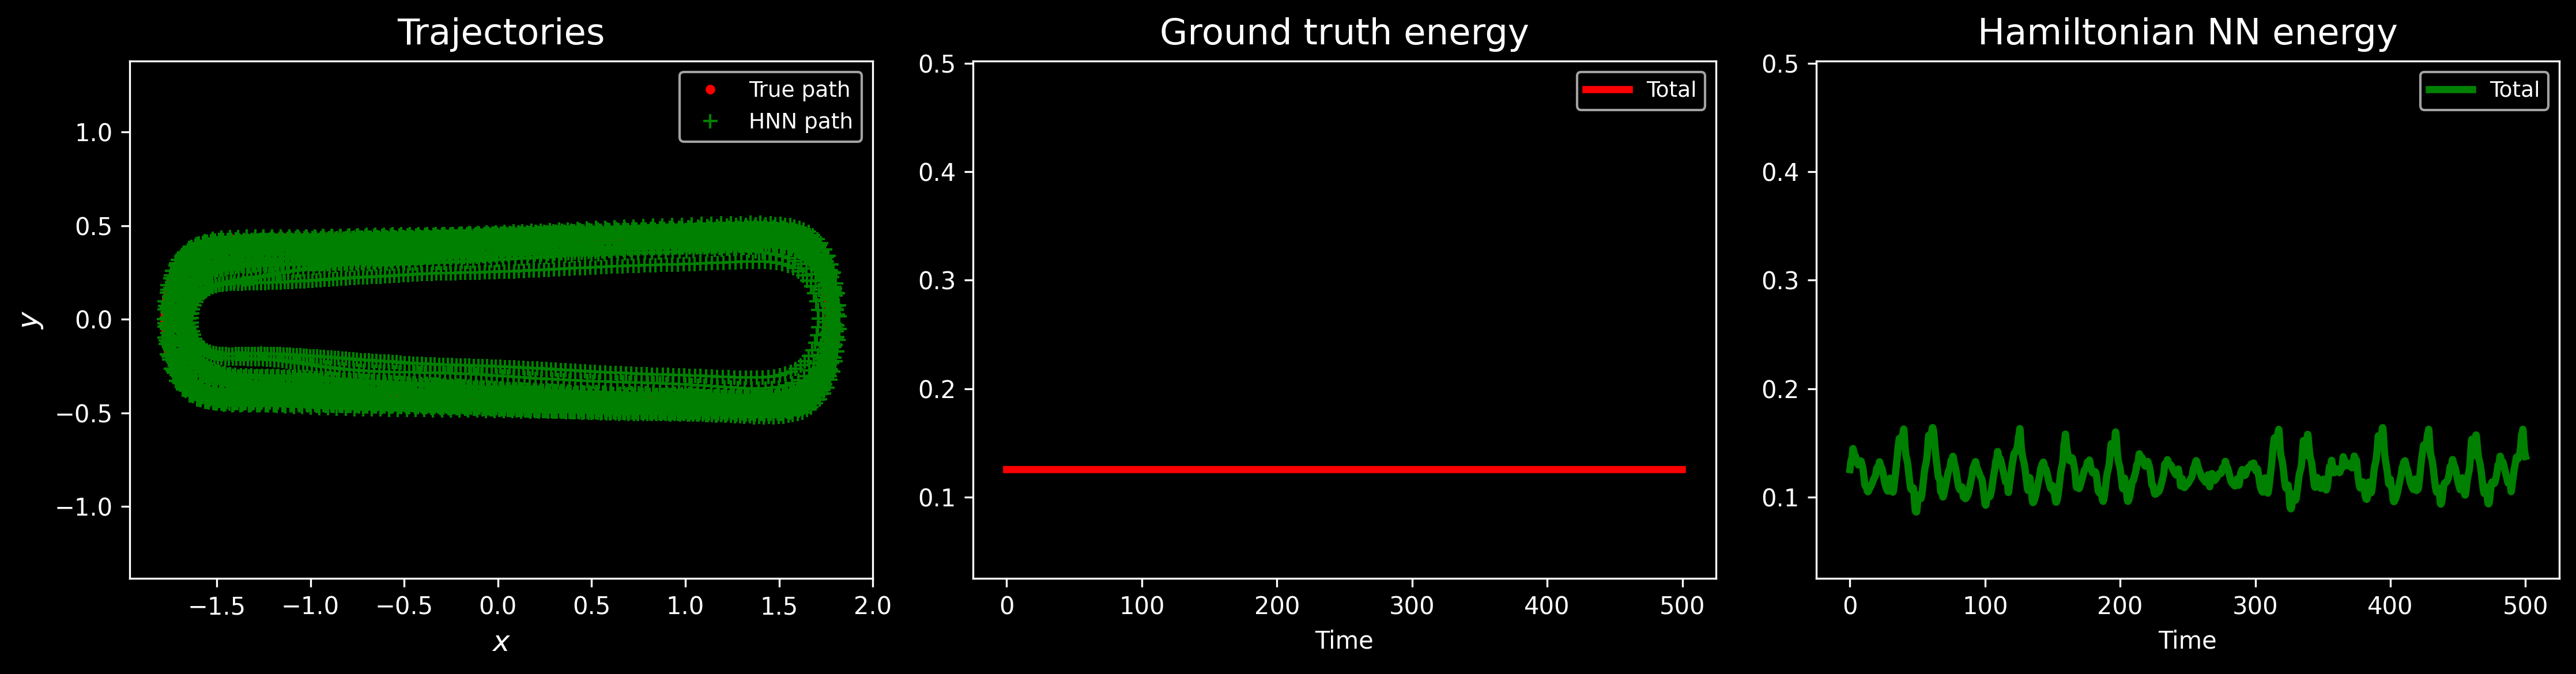

In [ ]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12


fig = plt.figure(figsize=[15,4], dpi=DPI)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['red', 'green']

plt.plot(orbit[1,:], orbit[3,:], '.', c=colors[0], label='True path', linewidth=lw)
plt.plot(hnn_orbit[1,:], hnn_orbit[3,:], '+', c=colors[1], label='HNN path', linewidth=lw)
plt.xlim(2.0*np.min(orbit[1,:]), 2.0*np.max(orbit[1,:]))
plt.ylim(2.0*np.min(orbit[3,:]), 2.0*np.max(orbit[3,:]))

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_etot = sys.get_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_etot, 'r-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['t_span'])
ymin = 0.2*real_etot.min()
ymax = 4*real_etot.max()
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Hamiltonian NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], sys.get_energy(hnn_orbit), 'g-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
#plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()
#fig.savefig('{}/orbits-hnn-{}_nlayers_{}_integrator_{}.{}'.format(args.fig_dir,args.name,
#                                                len(args.hidden_dim),args.integrator,FORMAT))